/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


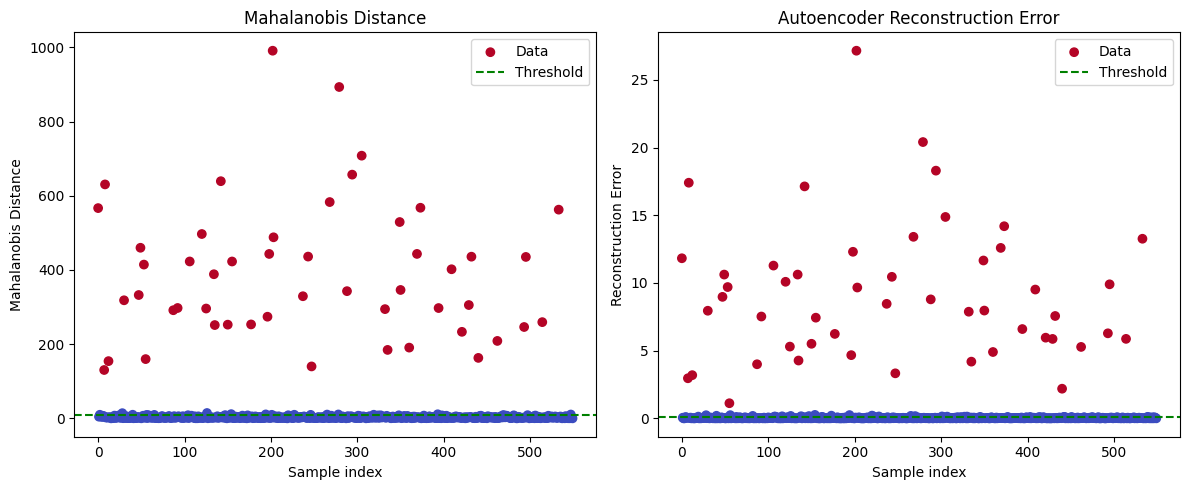

Mahalanobis: # detected anomalies = 75
Autoencoder: # detected anomalies = 75


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# ===================
# Simulate financial time series data
# ===================
np.random.seed(42)
n_normal = 500
n_anomalies = 50

# Normal: small daily returns
normal_data = np.random.normal(loc=0, scale=1, size=(n_normal, 3))

# Anomalies: large unexpected returns
anomaly_data = np.random.normal(loc=10, scale=5, size=(n_anomalies, 3))

# Combine
data = np.vstack([normal_data, anomaly_data])
labels = np.hstack([np.zeros(n_normal), np.ones(n_anomalies)])

# Shuffle
perm = np.random.permutation(len(data))
data, labels = data[perm], labels[perm]

# ===================
# Mahalanobis Distance Detection
# ===================
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

cov = EmpiricalCovariance().fit(data_scaled[labels == 0])
mahal_distances = cov.mahalanobis(data_scaled)

threshold_mahal = np.percentile(mahal_distances[labels == 0], 95)
pred_mahal = mahal_distances > threshold_mahal

# ===================
# Autoencoder Detection
# ===================
# Only fit on normal data
X_train = data_scaled[labels == 0]

autoencoder = Sequential([
    Dense(5, activation='relu', input_dim=3),
    Dense(2, activation='relu'),
    Dense(5, activation='relu'),
    Dense(3, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, verbose=0)

reconstructions = autoencoder.predict(data_scaled)
reconstruction_errors = np.mean(np.square(data_scaled - reconstructions), axis=1)

threshold_recon = np.percentile(reconstruction_errors[labels == 0], 95)
pred_auto = reconstruction_errors > threshold_recon

# ===================
# Visualization
# ===================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Mahalanobis Distance")
plt.scatter(range(len(mahal_distances)), mahal_distances, c=labels, cmap="coolwarm", label='Data')
plt.axhline(threshold_mahal, color='green', linestyle='--', label='Threshold')
plt.xlabel("Sample index")
plt.ylabel("Mahalanobis Distance")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Autoencoder Reconstruction Error")
plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, c=labels, cmap="coolwarm", label='Data')
plt.axhline(threshold_recon, color='green', linestyle='--', label='Threshold')
plt.xlabel("Sample index")
plt.ylabel("Reconstruction Error")
plt.legend()

plt.tight_layout()
plt.show()

# Print example flagged points
print("Mahalanobis: # detected anomalies =", np.sum(pred_mahal))
print("Autoencoder: # detected anomalies =", np.sum(pred_auto))


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


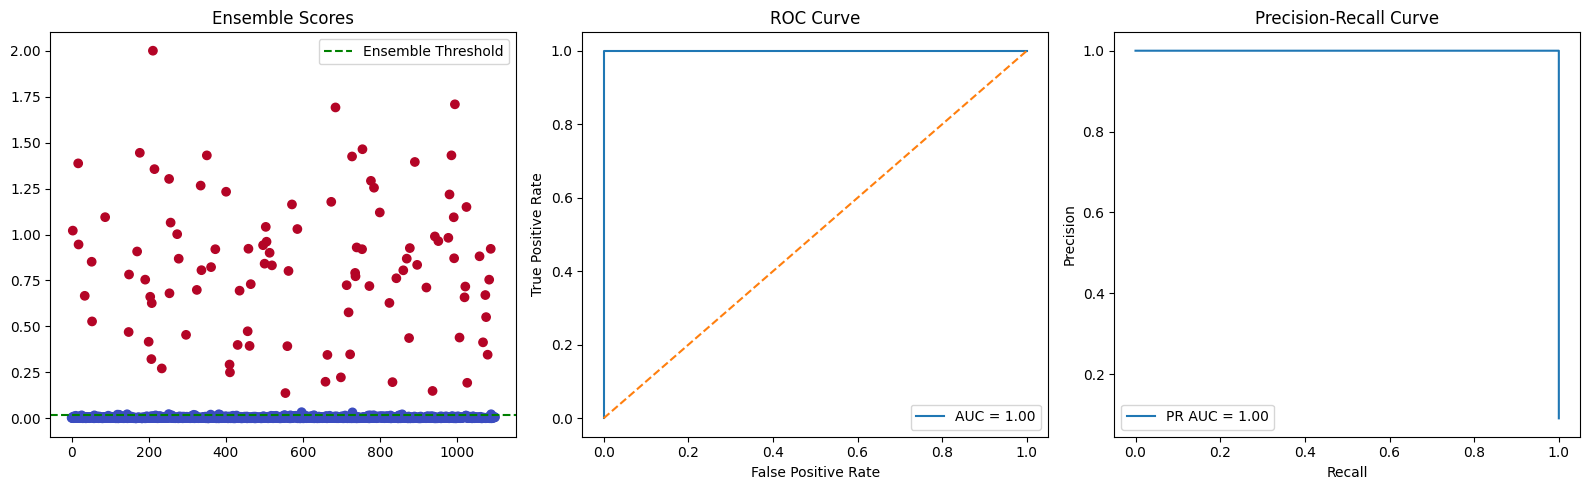

EV Mahalanobis threshold: 11.948392740449686
EV Autoencoder threshold: 0.8130350912479672
Ensemble confusion matrix:
 [[990  10]
 [  0 100]]
ROC AUC: 1.0
PR AUC: 1.0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Adversarial points flagged (should be few if perturbation small): 9


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense, Input
from scipy.stats import genpareto

np.random.seed(42)

# ======== Data generation ========
n_normal, n_anom = 1000, 100
normal_data = np.random.normal(loc=0, scale=1, size=(n_normal, 3))
anom_data = np.random.normal(loc=10, scale=5, size=(n_anom, 3))

data = np.vstack([normal_data, anom_data])
labels = np.hstack([np.zeros(n_normal), np.ones(n_anom)])
perm = np.random.permutation(len(data))
data, labels = data[perm], labels[perm]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# ======== Mahalanobis detector ========
cov = EmpiricalCovariance().fit(data_scaled[labels == 0])
mahal_dist = cov.mahalanobis(data_scaled)

# EVT fit on normal
normal_mahal = mahal_dist[labels == 0]
threshold_fit = normal_mahal - np.min(normal_mahal)
c = 0.5  # shape parameter for GPD (can be tuned)
params = genpareto.fit(threshold_fit)
ev_threshold_mahal = np.min(normal_mahal) + genpareto.ppf(0.99, *params)

# ======== Autoencoder detector ========
X_train = data_scaled[labels == 0]
autoencoder = Sequential([
    Input(shape=(3,)),
    Dense(5, activation='relu'),
    Dense(2, activation='relu'),
    Dense(5, activation='relu'),
    Dense(3, activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, verbose=0)

recon = autoencoder.predict(data_scaled)
recon_errors = np.mean(np.square(data_scaled - recon), axis=1)

# EVT on recon errors
normal_recon = recon_errors[labels == 0]
recon_fit = normal_recon - np.min(normal_recon)
params_recon = genpareto.fit(recon_fit)
ev_threshold_recon = np.min(normal_recon) + genpareto.ppf(0.99, *params_recon)

# ======== Ensemble scoring ========
ensemble_score = (mahal_dist / np.max(mahal_dist)) + (recon_errors / np.max(recon_errors))
ensemble_threshold = np.percentile(ensemble_score[labels == 0], 99)

# ======== Metrics ========
fpr, tpr, _ = roc_curve(labels, ensemble_score)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(labels, ensemble_score)
pr_auc = auc(recall, precision)

pred_labels = (ensemble_score > ensemble_threshold).astype(int)
conf_mat = confusion_matrix(labels, pred_labels)

# ======== Visualization ========
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.title("Ensemble Scores")
plt.scatter(range(len(ensemble_score)), ensemble_score, c=labels, cmap="coolwarm")
plt.axhline(ensemble_threshold, color='green', linestyle='--', label='Ensemble Threshold')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()

# ======== Print results ========
print("EV Mahalanobis threshold:", ev_threshold_mahal)
print("EV Autoencoder threshold:", ev_threshold_recon)
print("Ensemble confusion matrix:\n", conf_mat)
print("ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)

# ======== Optional: Adversarial perturbation test ========
perturbation = np.random.normal(0, 0.1, size=normal_data.shape)
adv_data = normal_data + perturbation
adv_scaled = scaler.transform(adv_data)

adv_mahal = cov.mahalanobis(adv_scaled)
adv_recon = autoencoder.predict(adv_scaled)
adv_errors = np.mean(np.square(adv_scaled - adv_recon), axis=1)

adv_ensemble = (adv_mahal / np.max(mahal_dist)) + (adv_errors / np.max(recon_errors))
adv_pred = adv_ensemble > ensemble_threshold

print("Adversarial points flagged (should be few if perturbation small):", np.sum(adv_pred))


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


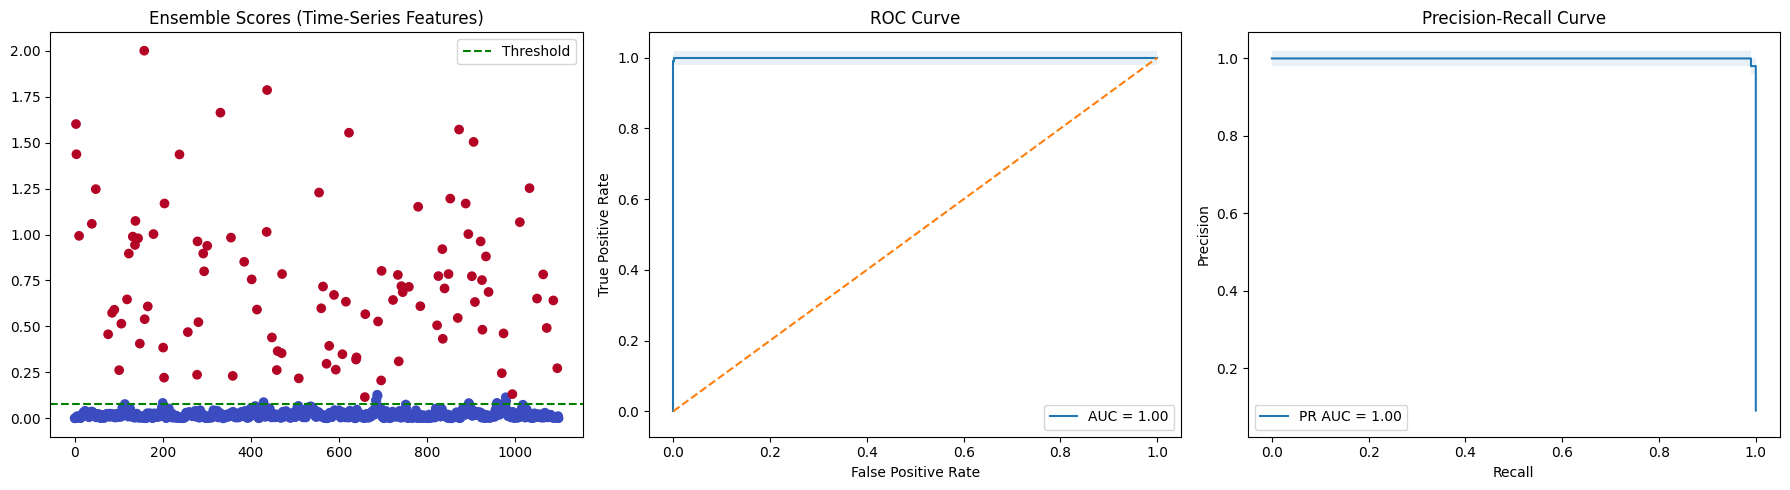

EV Mahalanobis threshold: 10.639133442488129
EV Autoencoder threshold: 1.2784839630443752
Ensemble confusion matrix:
 [[990  10]
 [  0 100]]
ROC AUC: 1.000, 95% CI: [1.000, 1.000]
PR AUC: 1.000, 95% CI: [0.999, 1.000]
FGSM adversarial points flagged: 20 / 1000


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve, auc
from sklearn.utils import resample
from keras.models import Sequential
from keras.layers import Dense, Input
from scipy.stats import genpareto
import tensorflow as tf

np.random.seed(42)

# ======== Data generation (AR(1) features) ========
def generate_ar1(n, phi=0.9, sigma=1.0):
    x = np.zeros(n)
    for t in range(1, n):
        x[t] = phi * x[t-1] + np.random.normal(scale=sigma)
    return x

n_points = 1100
features = np.vstack([generate_ar1(n_points), generate_ar1(n_points), generate_ar1(n_points)]).T

# Inject anomalies
n_anomalies = 100
anomaly_idx = np.random.choice(n_points, size=n_anomalies, replace=False)
features[anomaly_idx] += np.random.normal(10, 5, size=(n_anomalies, 3))

labels = np.zeros(n_points)
labels[anomaly_idx] = 1

scaler = StandardScaler()
data_scaled = scaler.fit_transform(features)

# ======== Mahalanobis detector ========
cov = EmpiricalCovariance().fit(data_scaled[labels == 0])
mahal_dist = cov.mahalanobis(data_scaled)

# EVT threshold for Mahalanobis
normal_mahal = mahal_dist[labels == 0]
threshold_fit = normal_mahal - np.min(normal_mahal)
params = genpareto.fit(threshold_fit)
ev_threshold_mahal = np.min(normal_mahal) + genpareto.ppf(0.99, *params)

# ======== Autoencoder detector ========
X_train = data_scaled[labels == 0]
autoencoder = Sequential([
    Input(shape=(3,)),
    Dense(5, activation='relu'),
    Dense(2, activation='relu'),
    Dense(5, activation='relu'),
    Dense(3, activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, verbose=0)

recon = autoencoder.predict(data_scaled)
recon_errors = np.mean(np.square(data_scaled - recon), axis=1)

# EVT threshold for autoencoder
normal_recon = recon_errors[labels == 0]
recon_fit = normal_recon - np.min(normal_recon)
params_recon = genpareto.fit(recon_fit)
ev_threshold_recon = np.min(normal_recon) + genpareto.ppf(0.99, *params_recon)

# ======== Ensemble scoring ========
ensemble_score = (mahal_dist / np.max(mahal_dist)) + (recon_errors / np.max(recon_errors))
ensemble_threshold = np.percentile(ensemble_score[labels == 0], 99)

# ======== Metrics and Confusion Matrix ========
fpr, tpr, _ = roc_curve(labels, ensemble_score)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(labels, ensemble_score)
pr_auc = auc(recall, precision)

pred_labels = (ensemble_score > ensemble_threshold).astype(int)
conf_mat = confusion_matrix(labels, pred_labels)

# ======== Bootstrap-based confidence intervals ========
n_bootstrap = 1000
auc_scores = []
pr_scores = []

for _ in range(n_bootstrap):
    idx = np.random.choice(np.arange(len(labels)), size=len(labels), replace=True)
    boot_labels = labels[idx]
    boot_scores = ensemble_score[idx]
    try:
        fpr_b, tpr_b, _ = roc_curve(boot_labels, boot_scores)
        roc_auc_b = auc(fpr_b, tpr_b)
        precision_b, recall_b, _ = precision_recall_curve(boot_labels, boot_scores)
        pr_auc_b = auc(recall_b, precision_b)

        auc_scores.append(roc_auc_b)
        pr_scores.append(pr_auc_b)
    except:
        continue

roc_ci = (np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5))
pr_ci = (np.percentile(pr_scores, 2.5), np.percentile(pr_scores, 97.5))

# ======== FGSM adversarial perturbation test ========
X_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(X_tf)
    recon_tf = autoencoder(X_tf)
    loss = tf.reduce_mean(tf.square(X_tf - recon_tf))
grad = tape.gradient(loss, X_tf)
epsilon = 0.1
adv_examples = X_tf + epsilon * tf.sign(grad)
adv_examples = adv_examples.numpy()

adv_mahal = cov.mahalanobis(adv_examples)
adv_recon = autoencoder.predict(adv_examples)
adv_errors = np.mean(np.square(adv_examples - adv_recon), axis=1)
adv_ensemble = (adv_mahal / np.max(mahal_dist)) + (adv_errors / np.max(recon_errors))
adv_pred = adv_ensemble > ensemble_threshold

# ======== Visualization ========
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.title("Ensemble Scores (Time-Series Features)")
plt.scatter(range(len(ensemble_score)), ensemble_score, c=labels, cmap="coolwarm")
plt.axhline(ensemble_threshold, color='green', linestyle='--', label='Threshold')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.fill_between(fpr, tpr - 0.02, tpr + 0.02, alpha=0.1)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.fill_between(recall, precision - 0.02, precision + 0.02, alpha=0.1)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()

# ======== Print results ========
print("EV Mahalanobis threshold:", ev_threshold_mahal)
print("EV Autoencoder threshold:", ev_threshold_recon)
print("Ensemble confusion matrix:\n", conf_mat)
print(f"ROC AUC: {roc_auc:.3f}, 95% CI: [{roc_ci[0]:.3f}, {roc_ci[1]:.3f}]")
print(f"PR AUC: {pr_auc:.3f}, 95% CI: [{pr_ci[0]:.3f}, {pr_ci[1]:.3f}]")
print("FGSM adversarial points flagged:", np.sum(adv_pred), "/", len(adv_examples))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


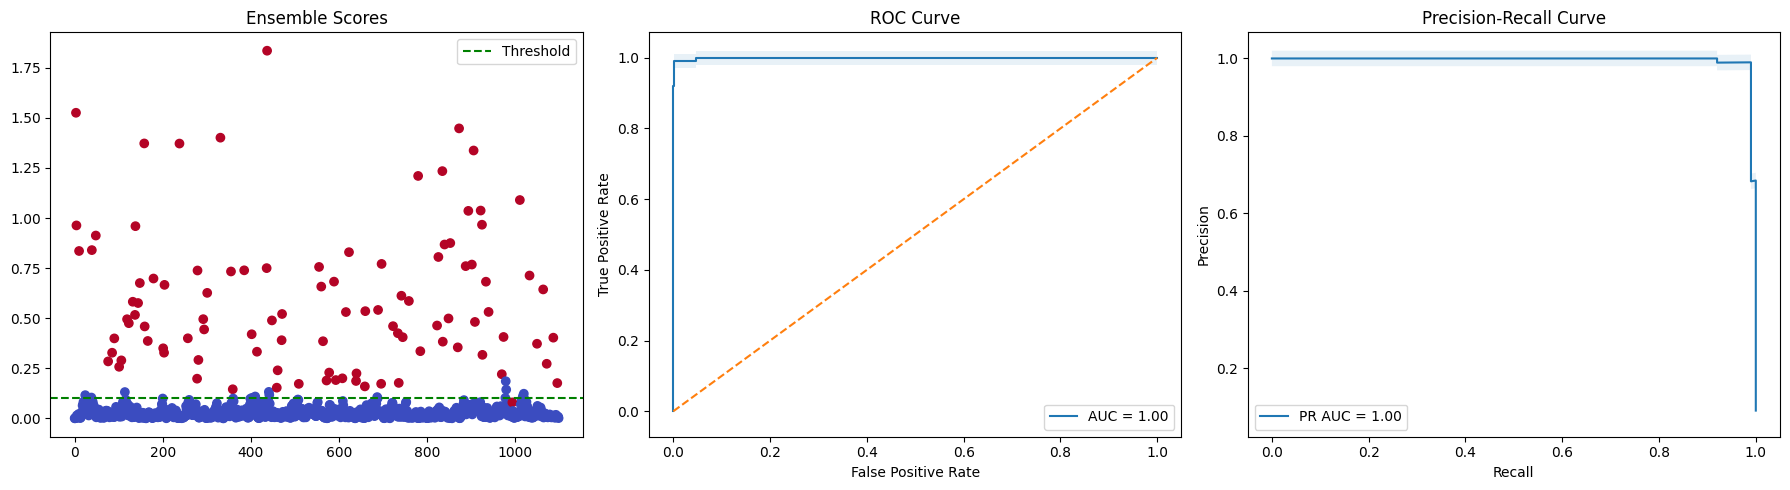

EV Mahalanobis threshold: 10.639133442488129
EV Autoencoder threshold: 1.0649210609525077
Ensemble confusion matrix:
 [[990  10]
 [  1  99]]
ROC AUC: 0.999, 95% CI: [0.998, 1.000]
PR AUC: 0.996, 95% CI: [0.989, 1.000]
FGSM adversarial points flagged: 45 / 1000


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.utils import resample
from keras.models import Sequential
from keras.layers import Dense, Input
from scipy.stats import genpareto
import tensorflow as tf

np.random.seed(42)

# ===================
# Time-Series (AR(1)) Data Simulation
# ===================
def generate_ar1(n, phi=0.9, sigma=1.0):
    x = np.zeros(n)
    for t in range(1, n):
        x[t] = phi * x[t-1] + np.random.normal(scale=sigma)
    return x

n_points = 1100
features = np.vstack([generate_ar1(n_points), generate_ar1(n_points), generate_ar1(n_points)]).T

# Inject anomalies
n_anomalies = 100
anomaly_idx = np.random.choice(n_points, size=n_anomalies, replace=False)
features[anomaly_idx] += np.random.normal(10, 5, size=(n_anomalies, 3))

labels = np.zeros(n_points)
labels[anomaly_idx] = 1

scaler = StandardScaler()
data_scaled = scaler.fit_transform(features)

# ===================
# Mahalanobis Detector
# ===================
cov = EmpiricalCovariance().fit(data_scaled[labels == 0])
mahal_dist = cov.mahalanobis(data_scaled)

# EVT threshold for Mahalanobis
normal_mahal = mahal_dist[labels == 0]
params = genpareto.fit(normal_mahal - np.min(normal_mahal))
ev_threshold_mahal = np.min(normal_mahal) + genpareto.ppf(0.99, *params)

# ===================
# Autoencoder Detector
# ===================
X_train = data_scaled[labels == 0]
autoencoder = Sequential([
    Input(shape=(3,)),
    Dense(5, activation='relu'),
    Dense(2, activation='relu'),
    Dense(5, activation='relu'),
    Dense(3, activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, verbose=0)

recon = autoencoder.predict(data_scaled)
recon_errors = np.mean(np.square(data_scaled - recon), axis=1)

# EVT threshold for Autoencoder
normal_recon = recon_errors[labels == 0]
params_recon = genpareto.fit(normal_recon - np.min(normal_recon))
ev_threshold_recon = np.min(normal_recon) + genpareto.ppf(0.99, *params_recon)

# ===================
# Ensemble Score
# ===================
ensemble_score = (mahal_dist / np.max(mahal_dist)) + (recon_errors / np.max(recon_errors))
ensemble_threshold = np.percentile(ensemble_score[labels == 0], 99)

# ===================
# Evaluation Metrics
# ===================
fpr, tpr, _ = roc_curve(labels, ensemble_score)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(labels, ensemble_score)
pr_auc = auc(recall, precision)

pred_labels = (ensemble_score > ensemble_threshold).astype(int)
conf_mat = confusion_matrix(labels, pred_labels)

# ===================
# Bootstrap Confidence Intervals
# ===================
n_bootstrap = 1000
auc_scores = []
pr_scores = []

for _ in range(n_bootstrap):
    idx = np.random.choice(np.arange(len(labels)), size=len(labels), replace=True)
    boot_labels = labels[idx]
    boot_scores = ensemble_score[idx]
    try:
        fpr_b, tpr_b, _ = roc_curve(boot_labels, boot_scores)
        roc_auc_b = auc(fpr_b, tpr_b)
        precision_b, recall_b, _ = precision_recall_curve(boot_labels, boot_scores)
        pr_auc_b = auc(recall_b, precision_b)
        auc_scores.append(roc_auc_b)
        pr_scores.append(pr_auc_b)
    except:
        continue

roc_ci = (np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5))
pr_ci = (np.percentile(pr_scores, 2.5), np.percentile(pr_scores, 97.5))

# ===================
# FGSM Adversarial Attack Test
# ===================
X_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(X_tf)
    recon_tf = autoencoder(X_tf)
    loss = tf.reduce_mean(tf.square(X_tf - recon_tf))
grad = tape.gradient(loss, X_tf)
epsilon = 0.1
adv_examples = X_tf + epsilon * tf.sign(grad)
adv_examples = adv_examples.numpy()

adv_mahal = cov.mahalanobis(adv_examples)
adv_recon = autoencoder.predict(adv_examples)
adv_errors = np.mean(np.square(adv_examples - adv_recon), axis=1)
adv_ensemble = (adv_mahal / np.max(mahal_dist)) + (adv_errors / np.max(recon_errors))
adv_pred = adv_ensemble > ensemble_threshold

# ===================
# Visualization
# ===================
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.title("Ensemble Scores")
plt.scatter(range(len(ensemble_score)), ensemble_score, c=labels, cmap="coolwarm")
plt.axhline(ensemble_threshold, color='green', linestyle='--', label='Threshold')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.fill_between(fpr, tpr - 0.02, tpr + 0.02, alpha=0.1)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.fill_between(recall, precision - 0.02, precision + 0.02, alpha=0.1)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()

# ===================
# Print results
# ===================
print("EV Mahalanobis threshold:", ev_threshold_mahal)
print("EV Autoencoder threshold:", ev_threshold_recon)
print("Ensemble confusion matrix:\n", conf_mat)
print(f"ROC AUC: {roc_auc:.3f}, 95% CI: [{roc_ci[0]:.3f}, {roc_ci[1]:.3f}]")
print(f"PR AUC: {pr_auc:.3f}, 95% CI: [{pr_ci[0]:.3f}, {pr_ci[1]:.3f}]")
print("FGSM adversarial points flagged:", np.sum(adv_pred), "/", len(adv_examples))
